In [3]:
import numpy as np

# Example sequence: categorical time series
weather_seq = ["sunny", "sunny", "rainy", "cloudy", "sunny", "rainy", "rainy"]

states = list(set(weather_seq))
n = len(states)
state_to_idx = {s: i for i, s in enumerate(states)}

# Transition matrix
transitions = np.zeros((n, n))
for i in range(len(weather_seq) - 1):
    a, b = weather_seq[i], weather_seq[i + 1]
    transitions[state_to_idx[a], state_to_idx[b]] += 1
transitions /= transitions.sum(axis=1, keepdims=True)

print("Transition Matrix:\n", transitions)

# Forecast next state given current
curr = "rainy"
probs = transitions[state_to_idx[curr]]
pred = states[np.argmax(probs)]
print(f"Given {curr} → next likely state = {pred}")

Transition Matrix:
 [[0.         0.         1.        ]
 [0.5        0.5        0.        ]
 [0.         0.66666667 0.33333333]]
Given rainy → next likely state = cloudy


In [4]:
import torch
import torch.nn as nn

# Encode categories
vocab = ["sunny", "rainy", "cloudy"]
stoi = {s: i for i, s in enumerate(vocab)}
seq = [stoi[w] for w in ["sunny", "rainy", "cloudy", "sunny", "rainy"]]

X = torch.tensor(seq[:-1]).unsqueeze(0)  # input
Y = torch.tensor(seq[1:]).unsqueeze(0)  # target

# Model


class CatLSTM(nn.Module):
    def __init__(self, vocab_size, hidden=16):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, 8)
        self.lstm = nn.LSTM(8, hidden, batch_first=True)
        self.fc = nn.Linear(hidden, vocab_size)

    def forward(self, x):
        x = self.embed(x)
        out, _ = self.lstm(x)
        return self.fc(out)


model = CatLSTM(len(vocab))
out = model(X)
pred_next = torch.argmax(out[0, -1]).item()
print("Predicted next:", vocab[pred_next])

Predicted next: sunny


In [5]:
from vega_datasets import data

df = data.seattle_weather()
df.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


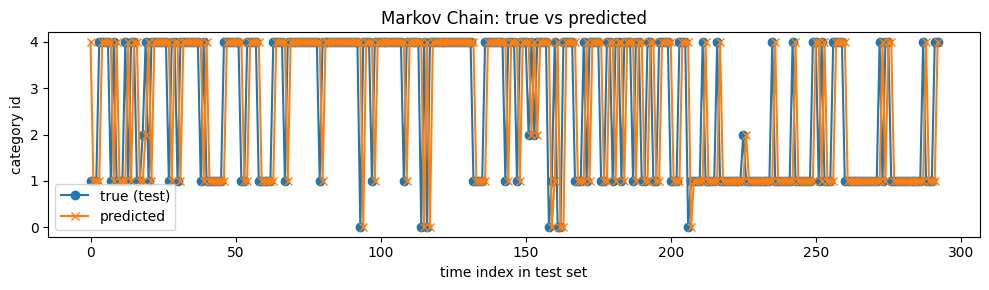

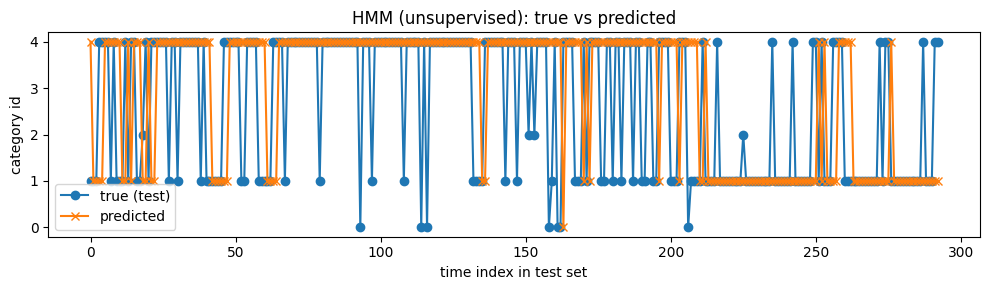

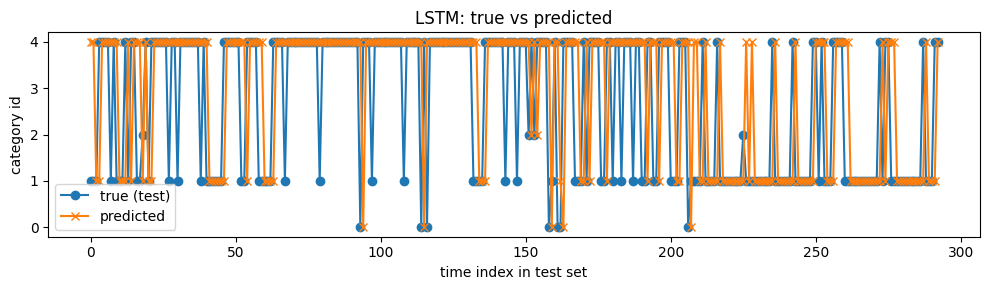

In [6]:
# Categorical time-series forecasting (Markov Chain, HMM, LSTM) on a real-world sample
#
# Dataset: small subset of the *Seattle Weather* daily dataset (2012–2015) originally compiled from NOAA
# Source references:
# - Vega-Lite Seattle Weather dataset & docs (NOAA-derived): https://vega.github.io/vega-lite/data/seattle-weather.csv
# - Altair case study describing the dataset: https://altair-viz.github.io/case_studies/exploring-weather.html
#
# Note: Because this environment has no internet access, we embed a small slice of the dataset below
# using values taken from public sources above (dates and daily "weather" category).
# With a larger slice (e.g., full 2012–2015), performance and stability will improve.


from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Encode categories
cats = sorted(df["weather"].unique())
stoi = {c: i for i, c in enumerate(cats)}  # string -> int
itos = {i: c for c, i in stoi.items()}  # int -> string
y = df["weather"].map(stoi).to_numpy()

# Train/test split (e.g., last 20% for test)
split = int(len(y) * 0.8)
train_y, test_y = y[:split], y[split:]


# ---- 2) Baseline: First-order Markov Chain ----
def estimate_markov_transitions(sequence, n_states):
    # transition counts
    counts = np.ones((n_states, n_states))  # Laplace smoothing
    for a, b in zip(sequence[:-1], sequence[1:]):
        counts[a, b] += 1
    # row-normalize
    return counts / counts.sum(axis=1, keepdims=True)


def predict_with_markov(trans_mat, history_last, horizon=1):
    preds = []
    current = history_last
    for _ in range(horizon):
        next_state = np.argmax(trans_mat[current])
        preds.append(next_state)
        current = next_state
    return np.array(preds)


n_states = len(cats)
T_hat = estimate_markov_transitions(train_y, n_states)
markov_preds = []
history_last = train_y[-1]
for true_next in test_y:
    pred = predict_with_markov(T_hat, history_last, horizon=1)[0]
    markov_preds.append(pred)
    history_last = true_next  # rolling one-step evaluation
markov_preds = np.array(markov_preds)
markov_acc = (markov_preds == test_y).mean() if len(test_y) > 0 else np.nan


# ---- 3) Unsupervised HMM (discrete emissions) via simple Baum-Welch ----
# We'll implement a very small HMM with K = number of observed categories.
# This HMM tries to learn hidden states and emission probs from the observed categories.
# For small data, it often converges to a permutation of categories.


def normalize_rows(A):
    A = A + 1e-12
    return A / A.sum(axis=1, keepdims=True)


def forward_backward(obs, pi, A, B):
    T = len(obs)
    K = len(pi)

    # Forward
    alpha = np.zeros((T, K))
    alpha[0] = pi * B[:, obs[0]]
    alpha[0] /= alpha[0].sum()
    for t in range(1, T):
        alpha[t] = (alpha[t - 1] @ A) * B[:, obs[t]]
        s = alpha[t].sum()
        if s == 0:
            alpha[t] = np.ones(K) / K
        else:
            alpha[t] /= s

    # Backward
    beta = np.zeros((T, K))
    beta[-1] = 1.0
    for t in range(T - 2, -1, -1):
        beta[t] = (A * B[:, obs[t + 1]].reshape(1, -1)).dot(beta[t + 1])
        s = beta[t].sum()
        if s == 0:
            beta[t] = np.ones(K) / K
        else:
            beta[t] /= s

    # Gamma & Xi
    gamma = alpha * beta
    gamma = gamma / gamma.sum(axis=1, keepdims=True)
    xi = np.zeros((T - 1, K, K))
    for t in range(T - 1):
        denom = (alpha[t].reshape(-1, 1) * A * B[:, obs[t + 1]].reshape(1, -1) * beta[t + 1]).sum()
        if denom == 0:
            xi[t] = np.ones((K, K)) / (K * K)
        else:
            xi[t] = (
                alpha[t].reshape(-1, 1) * A * B[:, obs[t + 1]].reshape(1, -1) * beta[t + 1]
            ) / denom

    return alpha, beta, gamma, xi


def baum_welch(obs, K, n_iter=50, seed=0):
    rng = np.random.default_rng(seed)
    # Initialize parameters
    pi = np.ones(K) / K
    A = normalize_rows(rng.random((K, K)))
    B = normalize_rows(rng.random((K, n_states)))  # emissions over observed categories

    for _ in range(n_iter):
        alpha, beta, gamma, xi = forward_backward(obs, pi, A, B)
        # Re-estimate
        pi = gamma[0] / gamma[0].sum()
        A = xi.sum(axis=0)
        A = normalize_rows(A)
        B = np.zeros((K, n_states)) + 1e-9
        for t, o in enumerate(obs):
            B[:, o] += gamma[t]
        B = normalize_rows(B)
    return pi, A, B


# Fit HMM on training observations
if len(train_y) >= 3:
    K = min(n_states, max(2, n_states))  # at least 2
    pi_hat, A_hat, B_hat = baum_welch(train_y, K=K, n_iter=75, seed=42)

    # One-step-ahead forecast for test: P(y_{t+1}|y_{1:t})
    hmm_preds = []
    # Start from last train observation: compute belief over hidden states conditioned on train sequence
    # Use forward pass on the train part to get last gamma as q(s_T)
    alpha, beta, gamma, xi = forward_backward(train_y, pi_hat, A_hat, B_hat)
    state_belief = gamma[-1]  # posterior over hidden states at last train time

    for obs_next in test_y:
        # Predict next observation distribution
        next_state_belief = state_belief @ A_hat  # q(s_{t+1})
        next_obs_dist = next_state_belief @ B_hat  # P(o_{t+1})
        pred_symbol = int(np.argmax(next_obs_dist))
        hmm_preds.append(pred_symbol)

        # Update belief with the *actual* observed symbol to continue rolling forecast
        like = B_hat[:, obs_next]
        post = next_state_belief * like
        if post.sum() == 0:
            state_belief = np.ones_like(post) / len(post)
        else:
            state_belief = post / post.sum()

    hmm_preds = np.array(hmm_preds)
    hmm_acc = (hmm_preds == test_y).mean() if len(test_y) > 0 else np.nan
else:
    hmm_preds = np.array([])
    hmm_acc = np.nan


# ---- 4) LSTM classifier over categorical tokens ----
import torch
import torch.nn as nn
import torch.optim as optim


class CatLSTM(nn.Module):
    def __init__(self, vocab_size, emb=8, hidden=32):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, emb)
        self.lstm = nn.LSTM(emb, hidden, batch_first=True)
        self.fc = nn.Linear(hidden, vocab_size)

    def forward(self, x):
        x = self.embed(x)
        out, _ = self.lstm(x)
        logits = self.fc(out)
        return logits


# Prepare training sequences (next-token prediction)
tokens = torch.tensor(train_y, dtype=torch.long)
# create (context -> next) pairs with window size W
W = 3
X, Y = [], []
for t in range(len(tokens) - W):
    X.append(tokens[t : t + W])
    Y.append(tokens[t + W])
if len(X) > 0:
    X = torch.stack(X).unsqueeze(1)  # (batch, 1, W)
    Y = torch.stack(Y)  # (batch,)
else:
    X = torch.zeros((0, 1, W), dtype=torch.long)
    Y = torch.zeros((0,), dtype=torch.long)

model = CatLSTM(vocab_size=n_states, emb=8, hidden=32)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.05)

# Train briefly (toy data → quick overfit is fine for demo)
if len(X) > 0:
    for epoch in range(60):
        optimizer.zero_grad()
        logits = model(X.squeeze(1))  # (batch, W, V)
        last_logits = logits[:, -1, :]  # predict next token from last step
        loss = criterion(last_logits, Y)
        loss.backward()
        optimizer.step()

# Rolling 1-step forecast on test
lstm_preds = []
context = (
    torch.tensor(train_y[-W:], dtype=torch.long)
    if len(train_y) >= W
    else torch.tensor(train_y, dtype=torch.long)
)
for true_next in test_y:
    if len(context) < W:
        # pad with first element if too short
        pad = torch.tensor([context[0].item()] * (W - len(context)), dtype=torch.long)
        ctx = torch.cat([pad, context])
    else:
        ctx = context[-W:]
    with torch.no_grad():
        logits = model(ctx.unsqueeze(0))[:, -1, :]  # (1, V)
        pred = int(torch.argmax(logits, dim=-1).item())
    lstm_preds.append(pred)
    # roll context with true_next
    context = torch.cat([context, torch.tensor([true_next])])
lstm_preds = np.array(lstm_preds)
lstm_acc = (lstm_preds == test_y).mean() if len(test_y) > 0 else np.nan


# ---- 5) Compare & visualize ----
results = pd.DataFrame(
    {
        "metric": ["accuracy (1-step, rolling)"],
        "Markov": [markov_acc],
        "HMM": [hmm_acc],
        "LSTM": [lstm_acc],
    }
)


# Plot true vs predicted categories over test window
def plot_timeline(true_seq, pred_seq, title):
    plt.figure(figsize=(10, 3))
    plt.plot(range(len(true_seq)), true_seq, marker="o", label="true (test)")
    if len(pred_seq) > 0:
        plt.plot(range(len(pred_seq)), pred_seq, marker="x", label="predicted")
    plt.xlabel("time index in test set")
    plt.ylabel("category id")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


if len(test_y) > 0:
    plot_timeline(test_y, markov_preds, "Markov Chain: true vs predicted")
    plot_timeline(test_y, hmm_preds, "HMM (unsupervised): true vs predicted")
    plot_timeline(test_y, lstm_preds, "LSTM: true vs predicted")

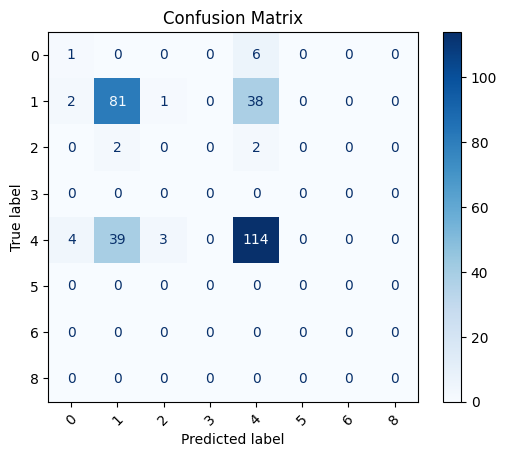

Classification Report:
              precision    recall  f1-score   support

           0      0.143     0.143     0.143         7
           1      0.664     0.664     0.664       122
           2      0.000     0.000     0.000         4
           3      0.000     0.000     0.000         0
           4      0.713     0.713     0.713       160
           5      0.000     0.000     0.000         0
           6      0.000     0.000     0.000         0
           8      0.000     0.000     0.000         0

    accuracy                          0.669       293
   macro avg      0.190     0.190     0.190       293
weighted avg      0.669     0.669     0.669       293

Accuracy: 0.669


/home/pranav-pc/projects/ts/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pranav-pc/projects/ts/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pranav-pc/projects/ts/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()}

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
)

# Example: true vs predicted
# y_true = ["sun", "rain", "sun", "fog", "rain", "rain", "sun"]
# y_pred = ["sun", "sun", "sun", "fog", "drizzle", "rain", "sun"]
y_true, y_pred = test_y, markov_preds
# 1. Unique labels
labels = np.unique(y_true + y_pred).tolist()

# 2. Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

# 3. Print detailed classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, labels=labels, digits=3))

# 4. Overall Accuracy
print(f"Accuracy: {accuracy_score(y_true, y_pred):.3f}")